In [1]:
from itertools import product
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from scipy import spatial
from datetime import datetime
from numpy.polynomial.polynomial import polyfit
import xarray as xr
import pandas as pd
import numpy as np
import datetime
from dateutil import tz
import matplotlib.pyplot as plt 
from my_fun.nan_helper import nan_helper
from scipy.signal import savgol_filter
from math import sqrt
import collections

In [2]:
filename_nc  = '../../data/output/Peru_out_1_20160901-20170831.nc'
dir_output   = 'out'
name_table0  = 'stat_MB'
name_figMB   = 'MBtotal'
name_figMB2  = 'MBpos'
name_fig3    = 'SCHS_end'
name_table0  = 'stat_MB'
name_table1  = 'rmse_espacial_mod'
name_table2  = 'rmse_temporal_mod'
name_table3  = 'stat_temporal_stake'
name_table4  = 'stat_espacial_stake'
name_fig     = 'vali_temporal_mod2'
name_fig1    = 'vali_espacial_mod2'

DATA  = xr.open_dataset(filename_nc)
time_nc = DATA['time'].values

stakes_loc_file = '../../data/input/Peru/loc_stakes1.csv'
stakes_data_file = '../../data/input/Peru/data_stakes_peru_year1.csv'
df_stakes_loc = pd.read_csv(stakes_loc_file, delimiter='\t', na_values='-9999')
df_stakes_data = pd.read_csv(stakes_data_file, delimiter='\t', index_col='TIMESTAMP', na_values='-9999')
df_stakes_data.index = pd.to_datetime(df_stakes_data.index)
df_stakes_data = df_stakes_data.cumsum(axis=0)
df_stakes_data = df_stakes_data-30
df_stakes_data

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18
TIMESTAMP,,,,,,,,,,,,,,,,,,
2016-09-06,-0.15,-0.15,-0.150,-0.150,-0.15,-0.150,-0.150,-0.150,-0.150,-0.150,-0.150,-0.15,-0.15,-0.15,-0.15,-0.150,-0.15,-0.150
2016-10-25,-1.53,-1.66,-1.520,-1.410,-1.89,-2.050,-1.300,-1.440,-1.930,-1.680,-1.320,-1.44,-1.37,-1.44,-1.36,-1.440,-1.32,-1.350
2016-12-26,-4.49,-3.73,-3.870,-3.740,-4.80,-4.580,-4.160,-3.730,-4.275,-4.080,-5.020,-3.74,-3.78,-3.57,-3.46,-3.540,-2.71,-3.120
2017-01-23,-5.56,-4.47,-4.585,-4.310,-5.50,-5.085,-4.775,-4.220,-4.753,-4.545,-5.450,-4.07,-4.23,-4.04,-3.85,-3.880,-2.97,-3.320
2017-02-22,-6.34,-5.24,-5.395,-5.040,-6.43,-5.740,-5.600,-4.960,-5.438,-5.160,-6.000,-4.69,-4.84,-4.71,-4.33,-4.425,-4.36,-3.650
2017-03-20,-6.86,-5.77,-5.900,-5.455,-6.80,-6.170,-5.900,-5.295,-5.738,-5.600,-6.365,-4.90,-5.13,-4.96,-4.60,-4.600,-4.50,-3.755
2017-04-26,-7.87,-6.87,-6.790,-6.405,-7.95,-7.340,-7.080,-6.456,-6.928,-6.743,-7.460,-5.47,-6.00,-5.81,-5.36,-5.440,-5.13,-4.255
2017-05-30,-9.02,-7.95,-8.040,-7.385,-8.88,-8.210,-7.840,-7.076,-7.458,-7.293,-8.180,-6.09,-6.52,-6.24,-5.82,-5.870,-5.59,-4.645
2017-06-15,-9.33,-8.34,-8.320,-7.905,-9.21,-8.520,-8.190,-7.376,-7.788,-7.673,-8.590,-6.43,-6.97,-6.56,-6.09,-6.180,-5.95,-4.885


In [3]:
def transform_coordinates(coords):
    """ Transform coordinates from geodetic to cartesian
    an array of tuples)
    """
    # WGS 84 reference coordinate system parameters
    A = 6378.137 # major axis [km]   
    E2 = 6.69437999014e-3 # eccentricity squared    
    
    coords = np.asarray(coords).astype(np.float)
                                                      
    # is coords a tuple? Convert it to an one-element array of tuples
    if coords.ndim == 1:
        coords = np.array([coords])
    
    # convert to radiants
    lat_rad = np.radians(coords[:,0])
    lon_rad = np.radians(coords[:,1]) 
    
    # convert to cartesian coordinates
    r_n = A / (np.sqrt(1 - E2 * (np.sin(lat_rad) ** 2)))
    x = r_n * np.cos(lat_rad) * np.cos(lon_rad)
    y = r_n * np.cos(lat_rad) * np.sin(lon_rad)
    z = r_n * (1 - E2) * np.sin(lat_rad)
    
    return np.column_stack((x, y, z))

In [4]:
lon_mesh, lat_mesh = np.meshgrid(DATA.lon.values, DATA.lat.values)

coords = np.column_stack((lat_mesh.ravel(), lon_mesh.ravel()))

ground_pixel_tree = spatial.cKDTree(transform_coordinates(coords))

 # Check for stake data
stakes_list = []
for index, row in df_stakes_loc.iterrows():
    index = ground_pixel_tree.query(transform_coordinates((row['lat'], row['lon'])))
    index = np.unravel_index(index[1], lat_mesh.shape)
    stakes_list.append((index[0][0], index[1][0], row['id']))


northing = 'lat' # name of dimension	in in- and -output
easting  = 'lon' # name of dimension in in- and -output
stake_names = []
TOTALHEIGHT_mod = np.zeros((len(DATA.time), len(stakes_list)))
for i in range(len(stakes_list)):
    for j in range(len(DATA.time)):
        tp1 = stakes_list[i]
        stake_loc_y = tp1[0]
        stake_loc_x = tp1[1]
        stake_name  = tp1[2]
        TOTALHEIGHT_mod[j,i] = DATA.TOTALHEIGHT.values[j,stake_loc_y,stake_loc_x]
    stake_names.append(stake_name)


df = pd.DataFrame(TOTALHEIGHT_mod,time_nc, columns = stake_names)

df = df - 30
df2 = df.loc[df_stakes_data.index]

In [5]:
df2

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18
TIMESTAMP,,,,,,,,,,,,,,,,,,
2016-09-06,-0.192233,-0.189696,-0.184947,-0.184386,-0.189116,-0.190255,-0.184905,-0.183888,-0.183493,-0.185493,-0.188628,-0.188816,-0.187231,-0.184528,-0.183802,-0.186877,-0.187499,-0.186936
2016-10-25,-1.888072,-1.838554,-1.734933,-1.728093,-1.780498,-1.798557,-1.723423,-1.727255,-1.708666,-1.706892,-1.747399,-1.728555,-1.703392,-1.681051,-1.645326,-1.641648,-1.648940,-1.653471
2016-12-26,-4.773297,-4.650388,-4.397719,-4.372773,-4.554783,-4.575289,-4.291185,-4.369284,-4.331883,-4.278192,-4.419787,-4.348608,-4.303704,-4.203717,-4.126042,-4.222980,-4.248870,-4.009720
2017-01-23,-5.417174,-5.269822,-4.956416,-4.878431,-5.116760,-5.129984,-4.804450,-4.906194,-4.853319,-4.795209,-4.947900,-4.868628,-4.760726,-4.700227,-4.579783,-4.688210,-4.723604,-4.374974
2017-02-22,-6.089454,-5.923988,-5.544495,-5.428862,-5.675833,-5.676490,-5.322210,-5.437916,-5.365397,-5.291213,-5.449662,-5.330140,-5.214316,-5.173089,-5.004830,-5.099224,-5.161776,-4.750599
2017-03-20,-5.963373,-5.774061,-5.327983,-5.187923,-5.431012,-5.421899,-5.058073,-5.191924,-5.102269,-5.020821,-5.170055,-5.039138,-4.906796,-4.861502,-4.684856,-4.776873,-4.845381,-4.396930
2017-04-26,-6.666392,-6.405296,-5.839985,-5.493669,-5.768442,-5.740326,-5.319178,-5.501630,-5.390497,-5.273899,-5.427265,-5.278163,-5.133923,-5.089041,-4.889148,-4.980728,-5.053982,-4.567964
2017-05-30,-7.725923,-7.445826,-6.847408,-6.316904,-6.675354,-6.586577,-6.093654,-6.338328,-6.176218,-6.022138,-6.187553,-5.812938,-5.476332,-5.462246,-5.076189,-5.154686,-5.226222,-4.714345
2017-06-15,-8.326340,-8.035648,-7.428600,-6.884074,-7.245400,-7.154833,-6.652880,-6.903572,-6.735104,-6.580267,-6.748045,-6.368887,-6.026556,-6.012013,-5.535136,-5.609010,-5.679158,-5.022187


In [6]:
tot_h_mod = df2.values
tot_h_obs = df_stakes_data.values

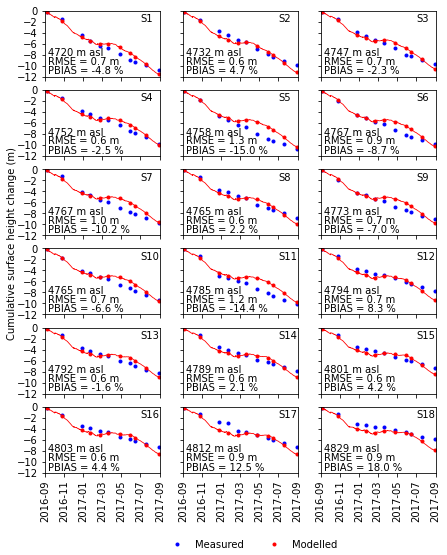

In [19]:
r_stake = []
R_stake = []
RMSE_stake = []
PBIAS_stake = []
i = 0
fig, axes = plt.subplots(nrows=6, ncols=3,figsize=(7.0,8.5))
for ax in axes.flat:
    ax.plot(df_stakes_data[stake_names[i]],'b.',lw=0.4, label='Measured')
    ax.plot(df[stake_names[i]],'r-',lw=0.8, label='Modelled')
    ax.plot(df2[stake_names[i]],'r.',lw=0.4, label='Modelled')
#    ax.set_title(stake_names[i])
    ax.set_ylim(-12,0)
    ax.set_yticks(np.arange(-12, 2, 2))
    ax.set_xlim(pd.Timestamp('2016-09-01'), pd.Timestamp('2017-09-01'))
    ax.xaxis.set_tick_params(which='major',rotation=90)
    mod_sta = tot_h_mod[:,i]
    obs_sta = tot_h_obs[:,i]
    corf_pearson = np.corrcoef(obs_sta,mod_sta)
    corf_pearson = np.round(corf_pearson[1,0], decimals=3)
    rms_stake = np.round(sqrt(mean_squared_error(obs_sta, mod_sta)),decimals=1)
    pbias = (np.round(100 *  (np.sum( mod_sta - obs_sta)/np.sum(obs_sta)),decimals=1))
    r_stake.append(corf_pearson)
    R_stake.append(np.round(np.square(corf_pearson),decimals=3))
    RMSE_stake.append(rms_stake)
    PBIAS_stake.append(pbias)
    
    ax.text(pd.Timestamp("2017-07-01"), -2, stake_names[i])
    ax.text(pd.Timestamp("2016-09-10"), -11.5, 'PBIAS ='+' '+str(pbias)+' '+'%')
    ax.text(pd.Timestamp("2016-09-10"), -9.8, 'RMSE ='+' '+str(rms_stake)+' '+'m')
    ax.text(pd.Timestamp("2016-09-10"), -8.2, str(df_stakes_loc['elev'][i])+' '+'m asl')

    i = i+1
    
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
entries = collections.OrderedDict()
for ax in axes.flatten():
  for handle, label in zip(*ax.get_legend_handles_labels()):
    entries[label] = handle

legend = fig.legend(entries.values(), entries.keys(),
    loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 0.04))

for ax in axes.flat:
    ax.label_outer()

fig.text(0.05, 0.5, 'Cumulative surface height change (m)', va='center', rotation='vertical')

font_f = 10
plt.rc('font', size=font_f)          # controls default text sizes
plt.rc('axes', titlesize=font_f)     # fontsize of the axes title
plt.rc('axes', labelsize=font_f)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_f)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_f)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_f)    # legend fontsize

fig.savefig(dir_output+'/'+name_fig+'.pdf',dpi = 300, bbox_inches = 'tight', 
             pad_inches = 0.1, format='pdf')

In [8]:
ind_spatial = np.array([r_stake, R_stake, PBIAS_stake, RMSE_stake]).T
ind_spatial = pd.DataFrame(ind_spatial, index = stake_names, columns=['r', 'R', 'PBIAS', 'RMSE'])
ind_spatial.index.name = 'stakes'
ind_spatial.to_csv(dir_output +'/'+ name_table1 +'.csv',sep='\t', float_format='%.3f')
ind_spatial

,r,R,PBIAS,RMSE
stakes,,,,
S1,0.979,0.958,-4.8,0.7
S2,0.982,0.964,4.7,0.6
S3,0.975,0.951,-2.3,0.7
S4,0.979,0.958,-2.5,0.6
S5,0.973,0.947,-15.0,1.3
S6,0.973,0.947,-8.7,0.9
S7,0.970,0.941,-10.2,1.0
S8,0.973,0.947,2.2,0.6
S9,0.971,0.943,-7.0,0.7


In [9]:
ind_spatial.mean()

r        0.970778
R        0.942500
PBIAS   -0.927778
RMSE     0.772222
dtype: float64

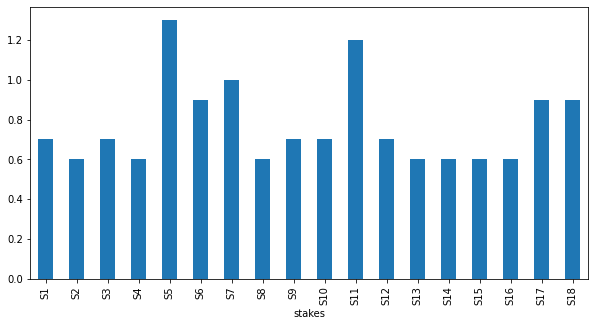

In [10]:
ind_spatial['RMSE'].plot(figsize=(10,5),kind='bar')

In [11]:
r_stake = []
R_stake = []
RMSE_stake = []
PBIAS_stake = []
i = 0
for i in range(len(tot_h_mod)):
    mod_sta = tot_h_mod[i,:]
    obs_sta = tot_h_obs[i,:]
    corf_pearson = np.corrcoef(obs_sta,mod_sta)
    corf_pearson = np.round(corf_pearson[1,0], decimals=3)
    rms_stake = np.round(sqrt(mean_squared_error(obs_sta, mod_sta)),decimals=1)
    pbias = (np.round(100 *  (np.sum( mod_sta - obs_sta)/np.sum(obs_sta)),decimals=1))
    r_stake.append(corf_pearson)
    R_stake.append(np.round(np.square(corf_pearson),decimals=3))
    RMSE_stake.append(rms_stake)
    PBIAS_stake.append(pbias)

/home/christian/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/christian/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [12]:
ind_temporal = np.array([r_stake, R_stake, PBIAS_stake, RMSE_stake]).T
ind_temporal = pd.DataFrame(ind_temporal, index = df2.index, columns=['r', 'R', 'PBIAS', 'RMSE'])
ind_temporal.index.name = 'date'
ind_temporal['r'][0] = 1
ind_temporal['R'][0] = 1
ind_temporal.to_csv(dir_output +'/'+ name_table2 +'.csv',sep='\t', float_format='%.3f')
ind_temporal

,r,R,PBIAS,RMSE
date,,,,
2016-09-06,1.000,1.000,24.5,0.0
2016-10-25,0.450,0.202,13.2,0.3
2016-12-26,0.627,0.393,11.5,0.7
2017-01-23,0.752,0.566,10.2,0.7
2017-02-22,0.823,0.677,5.0,0.5
2017-03-20,0.848,0.719,-6.2,0.6
2017-04-26,0.777,0.604,-15.2,1.2
2017-05-30,0.898,0.806,-14.7,1.2
2017-06-15,0.904,0.817,-11.4,1.0


In [13]:
ind_temporal.mean()

r        0.806909
R        0.672636
PBIAS    2.145455
RMSE     0.709091
dtype: float64

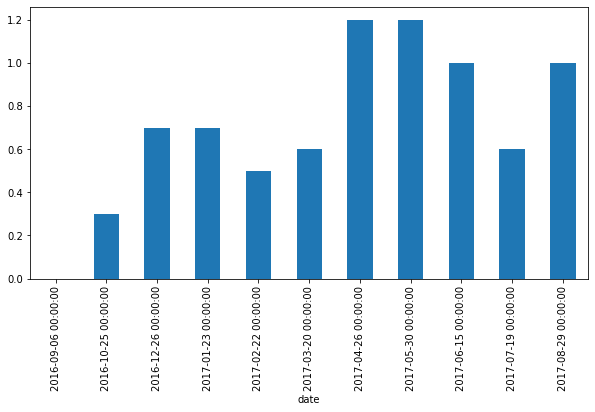

In [14]:
ind_temporal['RMSE'].plot(figsize=(10,5),kind='bar')

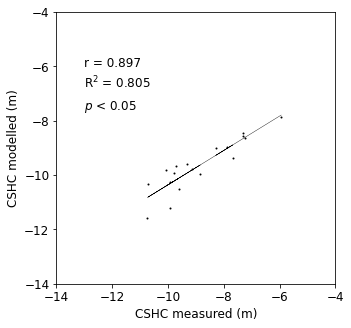

In [16]:
# end simulation of all stakes

tot_h_mod1 = tot_h_mod[10,:] # end simulation
tot_h_obs1 = tot_h_obs[10,:] # end observation
fig, (ax0) = plt.subplots(figsize=(5,5))
tot_h_mod_mean_esp = tot_h_mod1
tot_h_obs_mean_esp = tot_h_obs1
corf_pearson = np.corrcoef(tot_h_obs_mean_esp,tot_h_mod_mean_esp)
corf_pearson = corf_pearson[1,0]
b, m = polyfit(tot_h_obs_mean_esp, tot_h_mod_mean_esp, 1)
ax0.plot(tot_h_obs_mean_esp, tot_h_mod_mean_esp, 'k.', markersize=2)
ax0.plot(tot_h_obs_mean_esp, b + m * tot_h_obs_mean_esp, 'k-', lw=0.4)
ax0.set_yticks(np.arange(-14, 4, 2))
ax0.set_ylim((-14,-4))
ax0.set_xticks(np.arange(-14, 4, 2))
ax0.set_xlim((-14,-4))
ax0.text(-13, -6, 'r ='+' '+str(np.round(corf_pearson,decimals=3)))
ax0.text(-13, -6.8, 'R$^{2}$ ='+' '+str(np.round(np.square(corf_pearson),decimals=3)))
ax0.text(-13, -7.6, '$p$ <'+' '+'0.05')
ax0.set_xlabel('CSHC measured (m)')
ax0.set_ylabel('CSHC modelled (m)')
font_f = 12
plt.rc('font', size=font_f)          # controls default text sizes
plt.rc('axes', titlesize=font_f)     # fontsize of the axes title
plt.rc('axes', labelsize=font_f)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_f)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_f)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_f)    # legend fontsize

fig.savefig(dir_output+'/'+name_fig3+'.pdf',dpi = 300, bbox_inches = 'tight', 
             pad_inches = 0.1, format='pdf')